# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [66]:
import os
import shutil
import tqdm
import math
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array, check_X_y
from statstests.tests import overdisp, vuong_test
from typing import Dict, List, Set, Tuple, Optional
from sklearn.base import BaseEstimator, TransformerMixin, clone

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""
7475335,2010-01-01 00:14:00,1684,2140,26.46,"""Online Transaction""",39021,"""ONLINE""",null,null,"""4784""",null,"""Tolls and Bridge Fees""","""No""",56,65,1963,11,"""Male""","""27019 Madison Lane""",36.34,-83.28,13668.0,27861.0,108313.0,782,5,"""Mastercard""","""Debit (Prepaid)""",5955075527372953,"""05/2021""",513,"""YES""",1,46.0,"""03/2007""",2012,"""No"""


In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

### **Análise e Documentação Corrigida do Processo de Feature Engineering**

O script transforma dados transacionais brutos em um conjunto de features agregadas por janelas de tempo, prontas para serem usadas em modelos de detecção de fraude. O processo pode ser dividido em três etapas principais: tratamento de variáveis numéricas, categóricas e seleção final de features.

---

### ## 1. Agregação e Features Numéricas

As features numéricas são criadas agrupando os dados por uma janela de tempo (`date_window`) e aplicando as seguintes operações:

#### **Contagens e Razões**
São calculadas contagens e razões para entender o volume e a distribuição das transações em cada janela:
* `frauds`: Contagem total de fraudes (soma da coluna `target`).
* `transaction_per_client`: Média de transações por cliente único na janela.
* `transaction_per_merchant`: Média de transações por comerciante único na janela.

#### **Estatísticas de Comportamento**
Para um conjunto de colunas numéricas, são calculadas estatísticas para capturar a distribuição dos valores dentro da janela. Algumas dessas colunas são **normalizadas por um fator de escala** para manter os valores em uma ordem de magnitude similar.

* **Colunas com Fator de Escala:**
    * `amount` / 1.000
    * `per_capita_income` / 1.000
    * `total_debt` / 10.000
    * `credit_score` / 100
    * `credit_limit` / 10.000
* **Colunas Sem Fator de Escala:**
    * `current_age`
    * `num_credit_cards`

* **Estatísticas Geradas para as Colunas Acima:**
    * **Média (`mean_`):** Valor médio da feature na janela.
    * **Desvio Padrão (`std_`):** Dispersão dos valores da feature na janela.
    * **Mínimo (`min_`) e Máximo (`max_`):** O script calcula esses valores, mas as colunas `min_amount` e `max_amount` são **removidas** ao final desta etapa por serem consideradas menos informativas ou redundantes.

---

### ## 2. Features Categóricas (`city`, `country`, `description`)

O tratamento de variáveis categóricas é mais complexo e visa transformar categorias (como cidades) em representações numéricas que capturem seu risco de fraude. O fluxo é o seguinte:

1.  **Cálculo da Razão de Risco:** Para cada valor único de uma categoria (ex: para cada cidade), calcula-se a razão entre a porcentagem de transações fraudulentas e a porcentagem de transações não fraudulentas. Isso cria um "score de risco" para cada cidade.

2.  **Clusterização (KMeans):** As cidades são agrupadas (`clusterizadas`) em um número fixo de grupos (por padrão, 3) com base em seu "score de risco". Cidades com perfis de fraude semelhantes ficam no mesmo cluster.

3.  **Criação de Dummies:** Os clusters são transformados em colunas dummy (ex: `target_city_0`, `target_city_1`, `target_city_2`). Cada transação recebe o valor 1 na coluna do cluster correspondente à sua cidade e 0 nas outras.

4.  **Agregação por Janela (Proporção):** Finalmente, para cada janela de tempo, o script calcula a **proporção** de transações que pertencem a cada um dos clusters. Por exemplo, uma janela pode ter 70% de suas transações em cidades de "baixo risco" (cluster 0), 20% em cidades de "médio risco" (cluster 1) e 10% em cidades de "alto risco" (cluster 2).

O fluxo completo pode ser resumido como: **Razão de Risco → Clusterização → Variáveis Dummy → Proporção por Janela**.

---

### ## 3. Seleção de Features (Pós-processamento)

Após a criação de todas as features numéricas e categóricas, é executada uma etapa final de seleção para reduzir a redundância e o ruído:

* **Remoção de Features Altamente Correlacionadas:** O script calcula a matriz de correlação entre todas as features geradas. Se duas features tiverem uma correlação maior que um limiar (definido como **0.75**), aquela com a **menor variância** é removida. Isso ajuda a evitar problemas de multicolinearidade no modelo final.

In [8]:
class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    def __init__(self, df: pl.DataFrame):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns
            for column, scale_factor in self.SCALE_FACTORS.items():
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, scale_factor)
                    )

            # Add statistics for columns without scaling
            for column in ['current_age', 'num_credit_cards']:
                if column in df.columns:
                    agg_expressions.extend(
                        self._generate_column_statistics(column, 1.0)
                    )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
                .drop([
                    "transactions", "total_amount", "unique_clients", "unique_merchants"
                ] + [f"min_{col}" for col in ["amount"] if col in df.columns]
                  + [f"max_{col}" for col in ["amount"] if col in df.columns])
                .drop_nulls()
            )

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr()

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str, remove_high_correlation=True) -> pd.DataFrame:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')

        Returns:
            pandas DataFrame with engineered features ready for modeling

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Convert to pandas for correlation analysis
            df_pandas = df_with_categories.to_pandas()

            # Remove highly correlated features
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=['date_window'], errors='ignore')
            )

            if columns_to_remove and remove_high_correlation:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")

            return df_pandas.sort_values('date_window')

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'scale_factors': self.SCALE_FACTORS,
        }

### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [9]:
class BaselineCoutingModel:
  def __init__(self, df: pd.DataFrame, window: str):
    self.df = df
    self.models= []
    self.window = window
    # Adicione um mapeamento de nomes para facilitar a plotagem
    self.model_name_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial': self._plot_neg_binomial_dist, # Assumindo que Binomial na verdade é Binomial Negativa
        'Zip': self._plot_zip_dist,
        'Zimb': self._plot_zinb_dist,
    }

  # --- MÉTODOS DE TREINO (sem alterações) ---
  def train_poisson(self):
    return smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson()).fit()

  def train_binomial(self): # Este método treina um Binomial Negativo
    return sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df).fit(disp=False, maxiter=1000)

  def train_zip(self):
    return sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train_zimb(self):
    return sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train(self):
    # Ajustei os nomes para corresponder à implementação e ao gráfico desejado
    models = {'Poisson': self.train_poisson,
              'Binomial Negativa': self.train_binomial,
              'ZIP': self.train_zip,
              'ZINB': self.train_zimb}

    for model_name, action in models.items():
      print(f'Training BASELINE {model_name} with window {self.window}')
      try:
        model = action()
        self.models.append(dict(name=model_name, model=model))
      except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
    print('Baseline Models Trained')

  # --- MÉTODO DE RELATÓRIO (sem alterações) ---
  def get_report(self) -> pd.DataFrame:
    # ... (código do get_report como na resposta anterior)
    metrics = []
    for model in self.models:
      model_name = model.get('name')
      model_trained = model.get('model')
      rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
      outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
      metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
      if hasattr(model_trained, 'prsquared'):
        metric['PseudoR2'] = model_trained.prsquared
      elif hasattr(model_trained, 'pseudo_rsquared'):
         metric['PseudoR2'] = model_trained.pseudo_rsquared()
      else:
         metric['PseudoR2'] = 0.0
      metric['RMSE_Pearson'] = rmse_resid
      metric['Outliers'] = outliers
      metrics.append(metric)
    return pd.DataFrame(metrics)

  # --- NOVO MÉTODO DE PLOTAGEM ---
  def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
    """
    Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
    """
    if not self.models:
        print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
        return

    y = self.df[target_col]
    max_fraudes = int(y.max())
    bins = np.arange(0, max_fraudes + 2)
    total_obs = len(y)

    plt.style.use('seaborn-v0_8-whitegrid') # Estilo similar ao da imagem
    plt.figure(figsize=fig_size) # Tamanho maior para melhor visualização

    # 1. Plota a distribuição observada
    ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

    # 2. Plota a curva de cada modelo treinado
    plot_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial Negativa': self._plot_neg_binomial_dist,
        'ZIP': self._plot_zip_dist,
        'ZINB': self._plot_zinb_dist
    }

    for model_info in self.models:
        model_name = model_info['name']
        model_trained = model_info['model']

        if model_name in plot_map:
            plot_map[model_name](ax, model_trained, bins, total_obs)

    # 3. Finaliza o gráfico
    ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
    ax.set_xlabel('Fraudes', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
    plt.tight_layout()
    plt.show()

  # --- MÉTODOS AUXILIARES PARA PLOTAGEM ---
  def _plot_poisson_dist(self, ax, model, bins, total_obs):
    lambda_poisson = np.exp(model.params['Intercept'])
    poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
    ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

  def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
    mu_negbin = np.exp(model.params['Intercept'])
    alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None)) # Compatibilidade
    if alpha_negbin is None: return

    n = 1 / alpha_negbin
    p = n / (n + mu_negbin)
    negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

  def _plot_zip_dist(self, ax, model, bins, total_obs):
    lambda_zip = np.exp(model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

    zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
    zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
    zip_freq = zip_pmf * total_obs
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

  def _plot_zinb_dist(self, ax, model, bins, total_obs):
    mu_zinb = np.exp(model.params['Intercept'])
    alpha_zinb = model.params['alpha']
    pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

    n = 1 / alpha_zinb
    p = n / (n + mu_zinb)

    zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
    zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
    zinb_freq = zinb_pmf * total_obs
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [10]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [11]:
# def vuong_test(m1, m2):

#     from scipy.stats import norm

#     if m1.__class__.__name__ == "GLMResultsWrapper":

#         glm_family = m1.model.family

#         X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
#         y = pd.Series(m1.model.endog, name=m1.model.endog_names)

#         if glm_family.__class__.__name__ == "Poisson":
#             m1 = Poisson(endog=y, exog=X).fit()

#         if glm_family.__class__.__name__ == "NegativeBinomial":
#             m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

#     supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

#     if type(m1.model) not in supported_models:
#         raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

#     if type(m2.model) not in supported_models:
#         raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

#     # Extração das variáveis dependentes dos modelos
#     m1_y = m1.model.endog
#     m2_y = m2.model.endog

#     m1_n = len(m1_y)
#     m2_n = len(m2_y)

#     if m1_n == 0 or m2_n == 0:
#         raise ValueError("Could not extract dependent variables from models.")

#     if m1_n != m2_n:
#         raise ValueError("Models appear to have different numbers of observations.\n"
#                          f"Model 1 has {m1_n} observations.\n"
#                          f"Model 2 has {m2_n} observations.")

#     if np.any(m1_y != m2_y):
#         raise ValueError("Models appear to have different values on dependent variables.")

#     m1_linpred = pd.DataFrame(m1.predict(which="prob"))
#     m2_linpred = pd.DataFrame(m2.predict(which="prob"))

#     m1_probs = np.repeat(np.nan, m1_n)
#     m2_probs = np.repeat(np.nan, m2_n)

#     which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
#     which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

#     for i, v in enumerate(m1_probs):
#         m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

#     for i, v in enumerate(m2_probs):
#         m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

#     lm1p = np.log(m1_probs)
#     lm2p = np.log(m2_probs)

#     m = lm1p - lm2p

#     v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

#     pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

#     print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
#     print(f"Vuong z-statistic: {round(v, 3)}")
#     print(f"p-value: {pval:.3f}")
#     print("")
#     print("==================Result======================== \n")
#     if pval <= 0.05:
#         print("H1: Indicates inflation of zeros at 95% confidence level")
#     else:
#         print("H0: Indicates no inflation of zeros at 95% confidence level")

### Gráficos Auxiliares

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [32]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [12]:
class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor stepwise simplificado para modelos Zero-Inflated com validação de convergência.

    Esta versão simplificada foca em:
    - Seleção stepwise eficiente
    - Validação rigorosa de convergência do modelo
    - Critérios de parada inteligentes
    - Código limpo e manutenível

    Principais melhorias:
    - Validação de convergência em cada iteração
    - Detecção automática de instabilidade numérica
    - Early stopping baseado em múltiplos critérios
    - Código 10x mais simples que a versão original
    """

    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-6,
                 convergence_patience=3,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

In [13]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


#### RandomFeatureSelector

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn  # agora o usuário fornece essa função
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if score > best_score:
                best_score = score
                self.best_estimator_ = model
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

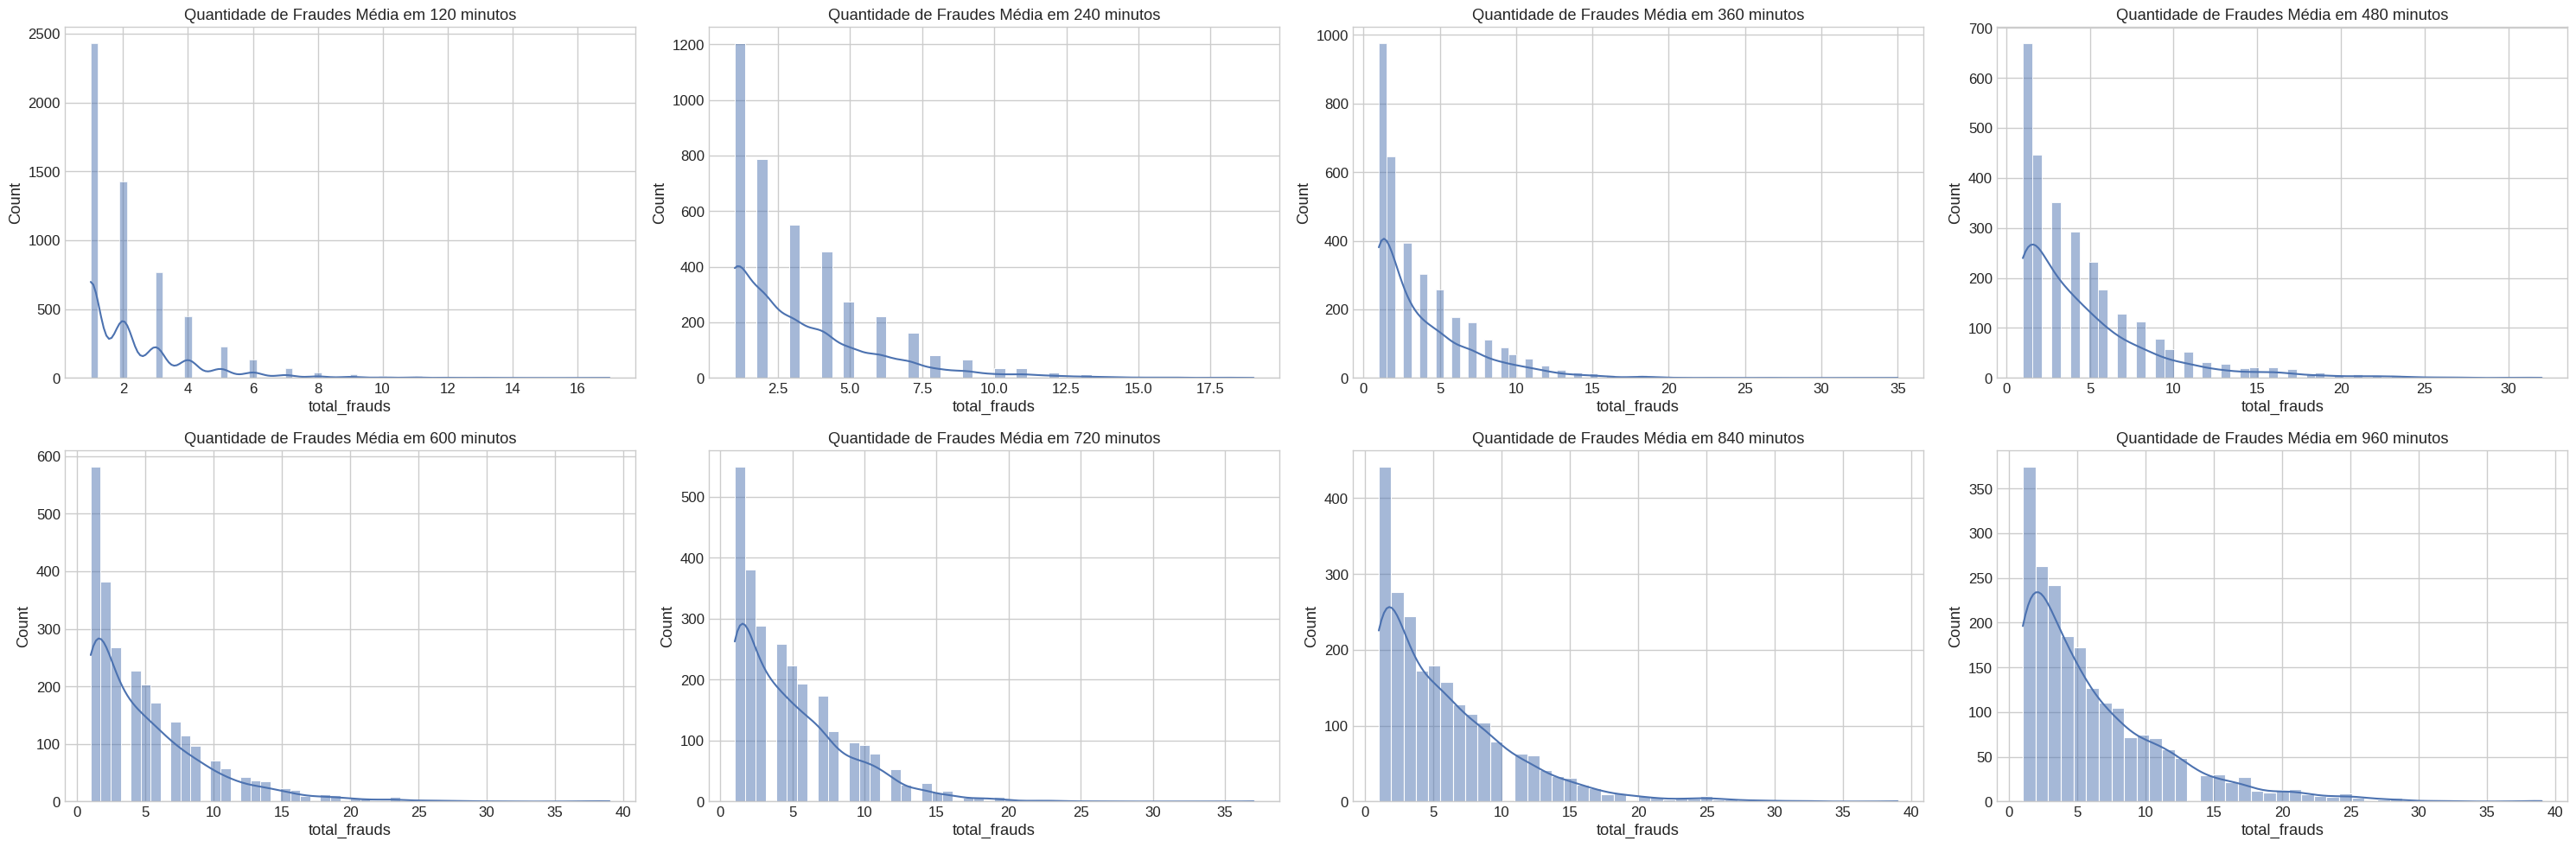

In [36]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [37]:
window_data_builder = WindowDataBuilder(df)

In [38]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):
  df_train = window_data_builder.build(f'{minute}m', False)

  builder = BaselineCoutingModel(df_train, f'{minute}m')
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/8 [00:00<?, ?it/s]

Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m
Baseline Models Trained
Training BASELINE Poisson with window 240m
Training BASELINE Binomial Negativa with window 240m
Training BASELINE ZIP with window 240m
Training BASELINE ZINB with window 240m
Baseline Models Trained
Training BASELINE Poisson with window 360m
Training BASELINE Binomial Negativa with window 360m
Training BASELINE ZIP with window 360m
Training BASELINE ZINB with window 360m
Baseline Models Trained
Training BASELINE Poisson with window 480m
Training BASELINE Binomial Negativa with window 480m
Training BASELINE ZIP with window 480m
Training BASELINE ZINB with window 480m
Baseline Models Trained
Training BASELINE Poisson with window 600m
Training BASELINE Binomial Negativa with window 600m
Training BASELINE ZIP with window 600m
Training BASELINE ZINB with window 600m
Baseline Models Trained
Train

In [39]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=True)
df_report.reset_index(drop=True, inplace=True)
df_report

,window,model_name,LLF,BIC,AIC,Converged,PseudoR2,RMSE_Pearson,Outliers
0,120m,Poisson,-36273.604984,-401387.909697,72549.209969,True,0.000000e+00,1.820327,3183
1,240m,Poisson,-30830.871549,-164337.621400,61663.743097,True,0.000000e+00,2.171882,1940
2,360m,Poisson,-27657.000514,-91942.236354,55316.001029,True,0.000000e+00,2.417245,1736
3,120m,ZIP,-26062.748669,52146.838596,52129.497339,True,-3.681522e-10,1.113878,1756
4,480m,Poisson,-26019.234583,-56528.888767,52040.469165,True,0.000000e+00,2.703015,1328
5,120m,Binomial Negativa,-25576.987256,51175.315768,51157.974512,True,5.846101e-11,0.925697,1756
6,600m,Poisson,-24092.703356,-37895.525961,48187.406711,True,8.881784e-16,2.777668,1309
7,840m,Poisson,-20865.122440,-19295.304037,41732.244881,True,0.000000e+00,2.817431,1100
8,720m,Poisson,-20782.606047,-30500.028095,41567.212094,True,0.000000e+00,2.496118,1148
9,960m,Poisson,-19912.276693,-13436.164987,39826.553386,True,-1.332268e-15,2.912284,868


In [40]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

,window,count,llf
0,960m,4,-10447.372246
1,840m,4,-10987.786173
2,720m,4,-11974.581516
3,480m,4,-13915.026582
4,360m,4,-16000.923081


### Seleção da melhor janela de tempo

In [41]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

,window,model_name,LLF,BIC,AIC,Converged,PseudoR2,RMSE_Pearson,Outliers
0,960m,Poisson,-19912.276693,-13436.164987,39826.553386,True,-1.332268e-15,2.912284,868
1,960m,Binomial Negativa,-9456.677230,18930.537949,18917.354461,True,7.036938e-11,0.817686,200
2,960m,ZIP,-11438.067262,22893.318011,22880.134524,True,-3.337508e-11,1.342494,453
3,960m,ZINB,-9331.161139,18688.097510,18668.322278,True,-4.173122e-10,0.978726,307


#### Visualização da distribuição observada dos eventos X modelo dummy

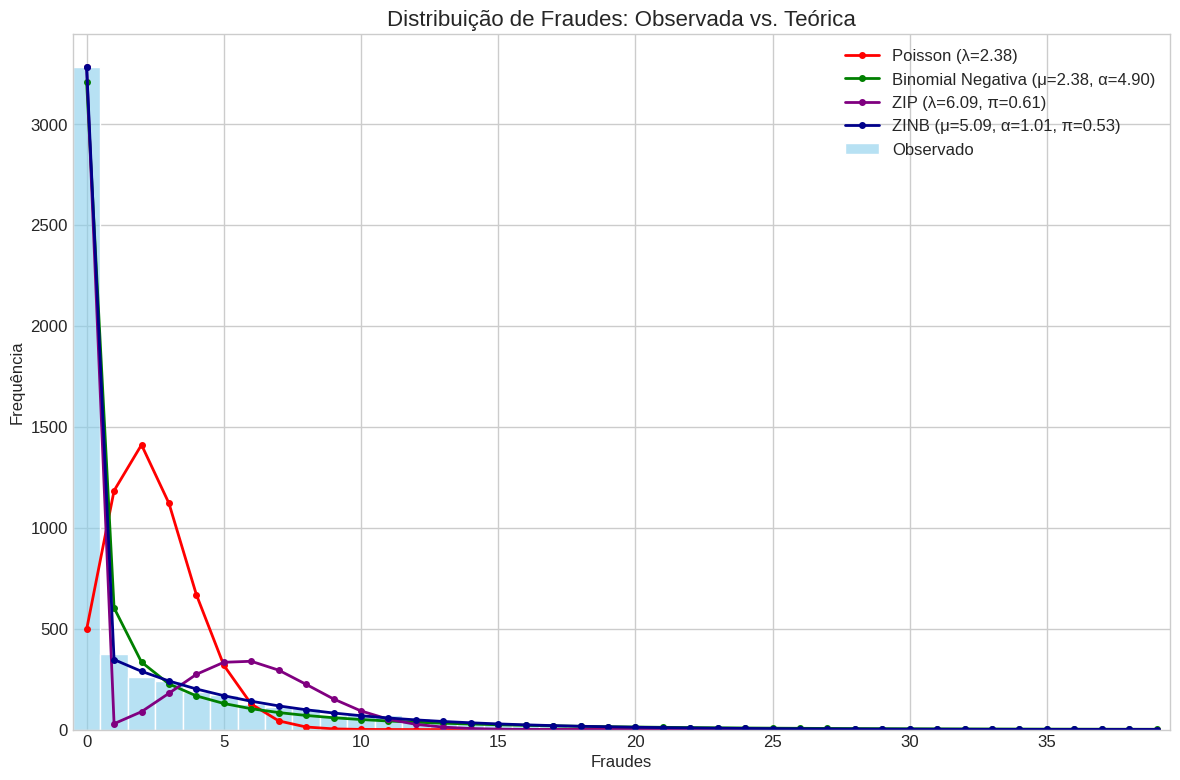

In [42]:
selected_builder.plot_theoretical_distributions()

#### Correlação dos dados no dataframe da janela selecionada

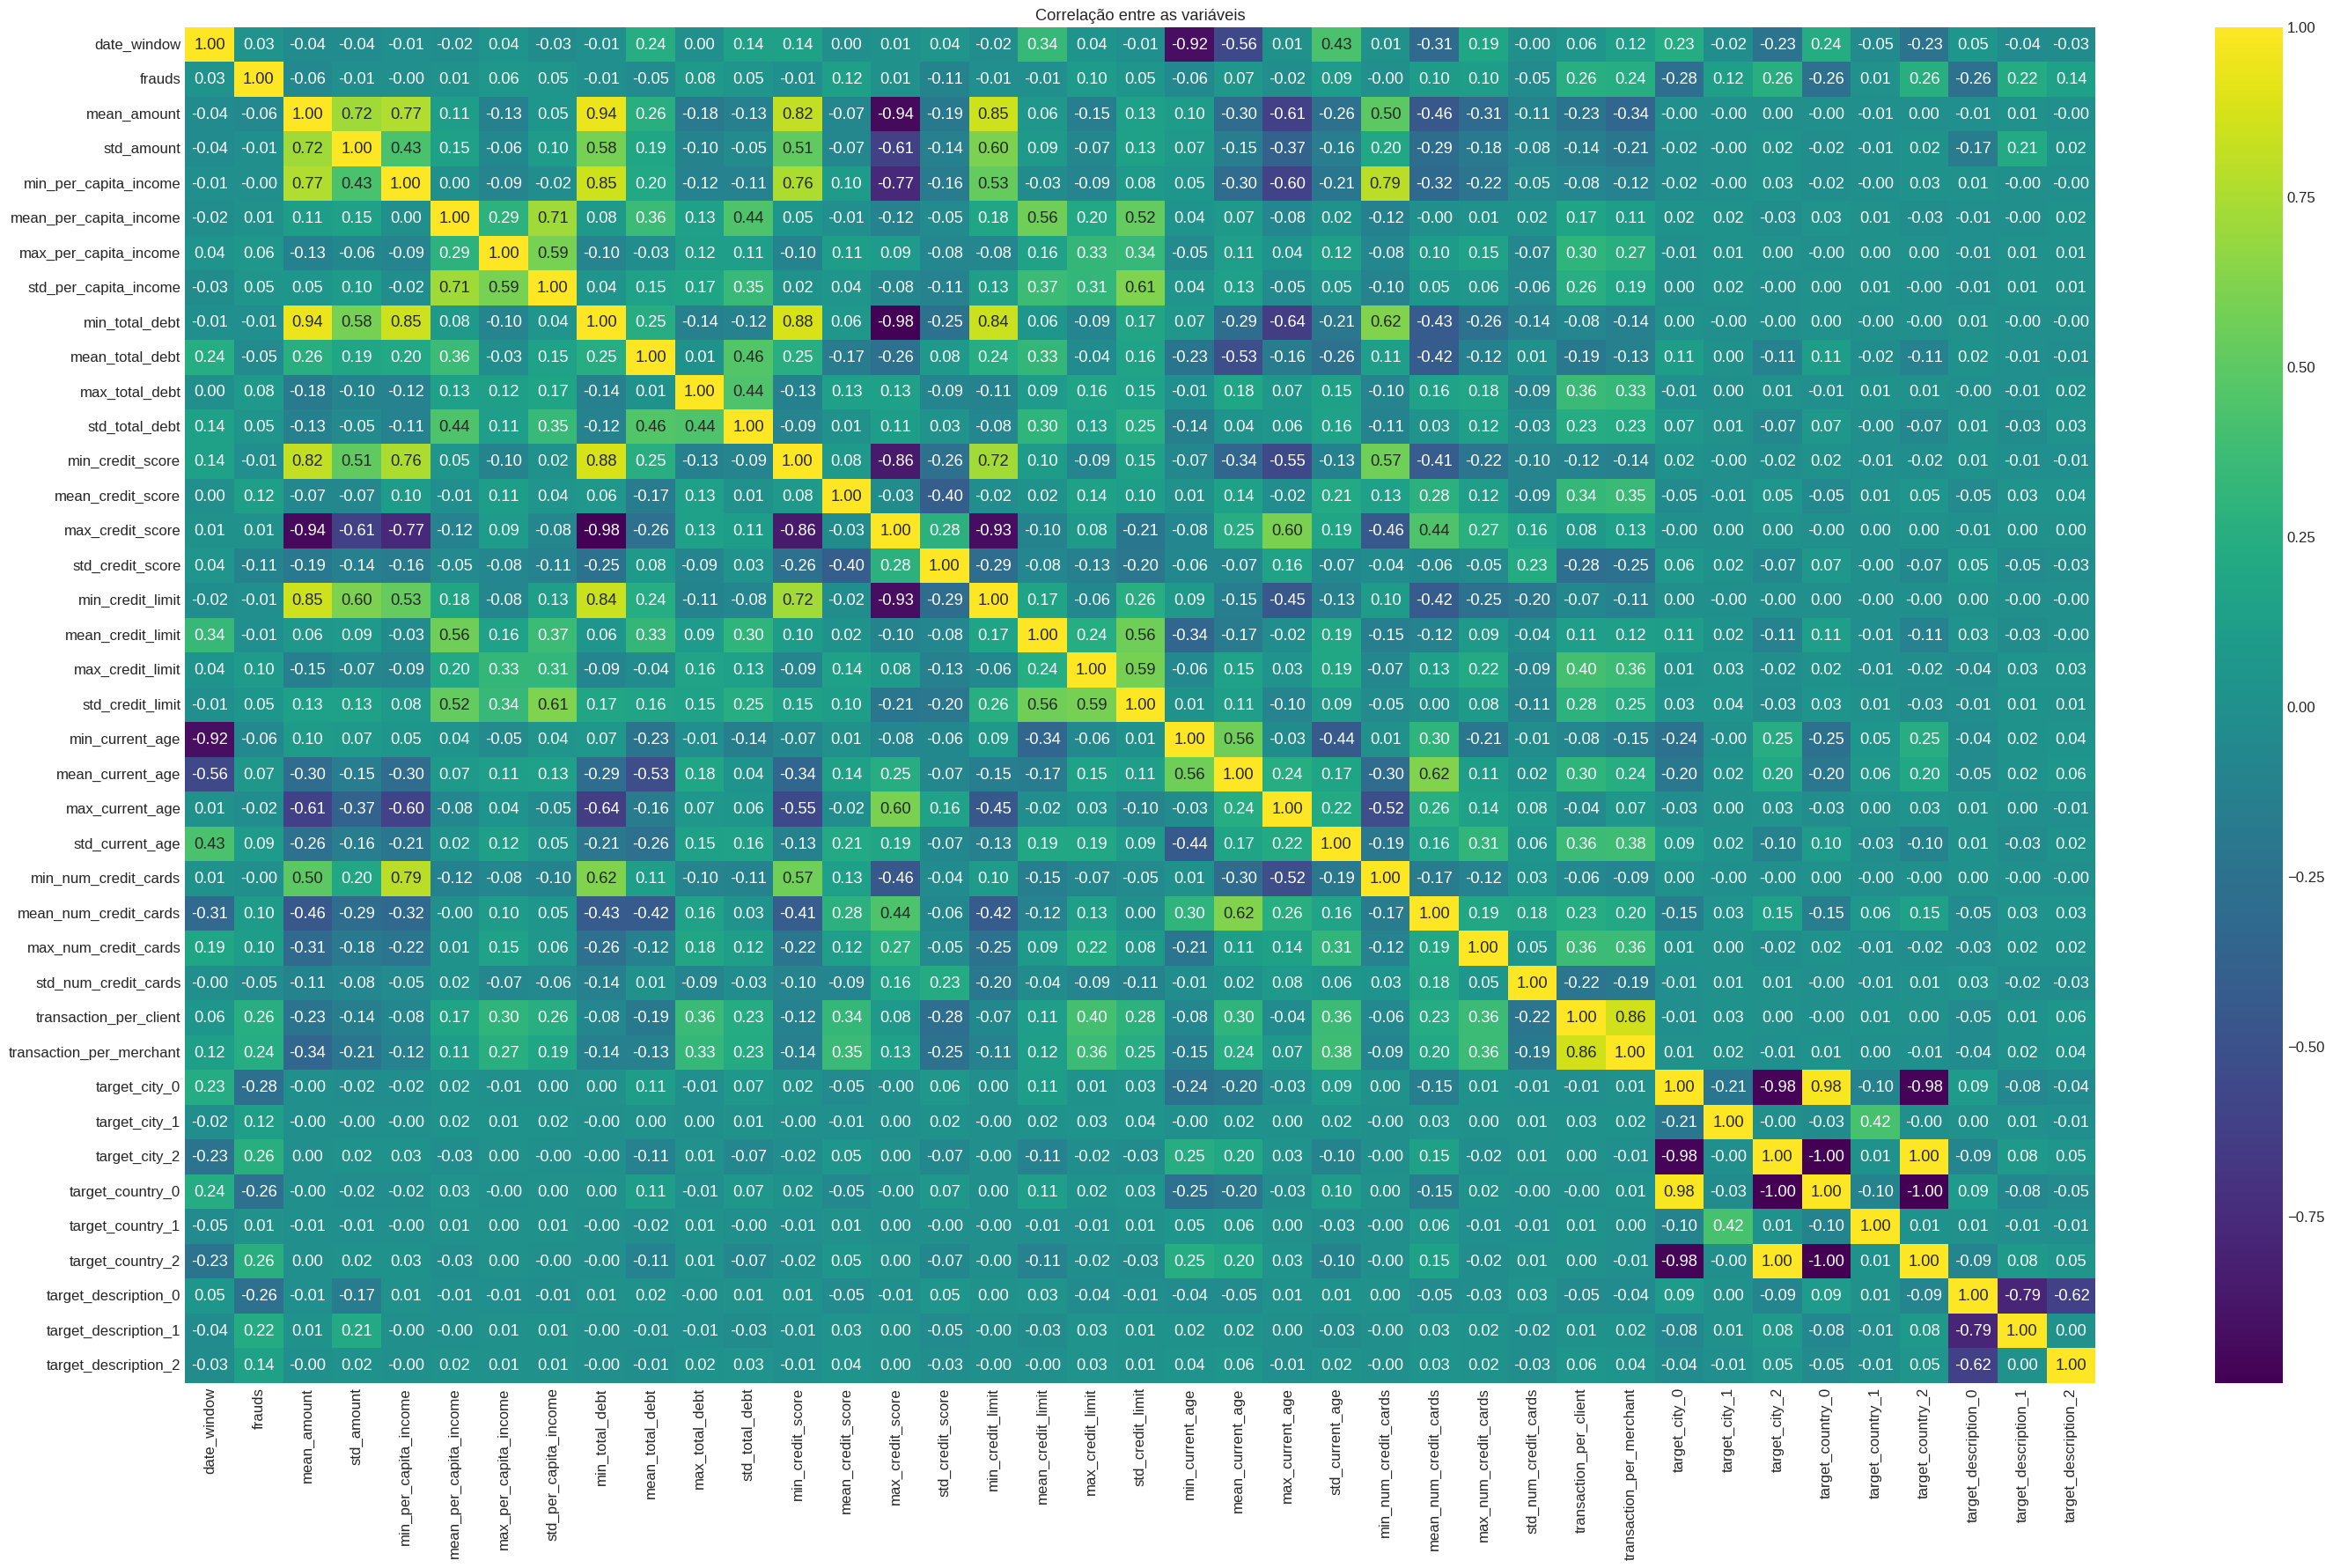

In [43]:
corr = selected_builder.df.corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

#### Correlação do dataframe após removação de variaveis com alta correlação

In [44]:
df_train = window_data_builder.build(selected_builder.window, True)
selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
builder.train()

Removed 10 highly correlated features
Training BASELINE Poisson with window 960m
Training BASELINE Binomial Negativa with window 960m
Training BASELINE ZIP with window 960m
Training BASELINE ZINB with window 960m
Baseline Models Trained


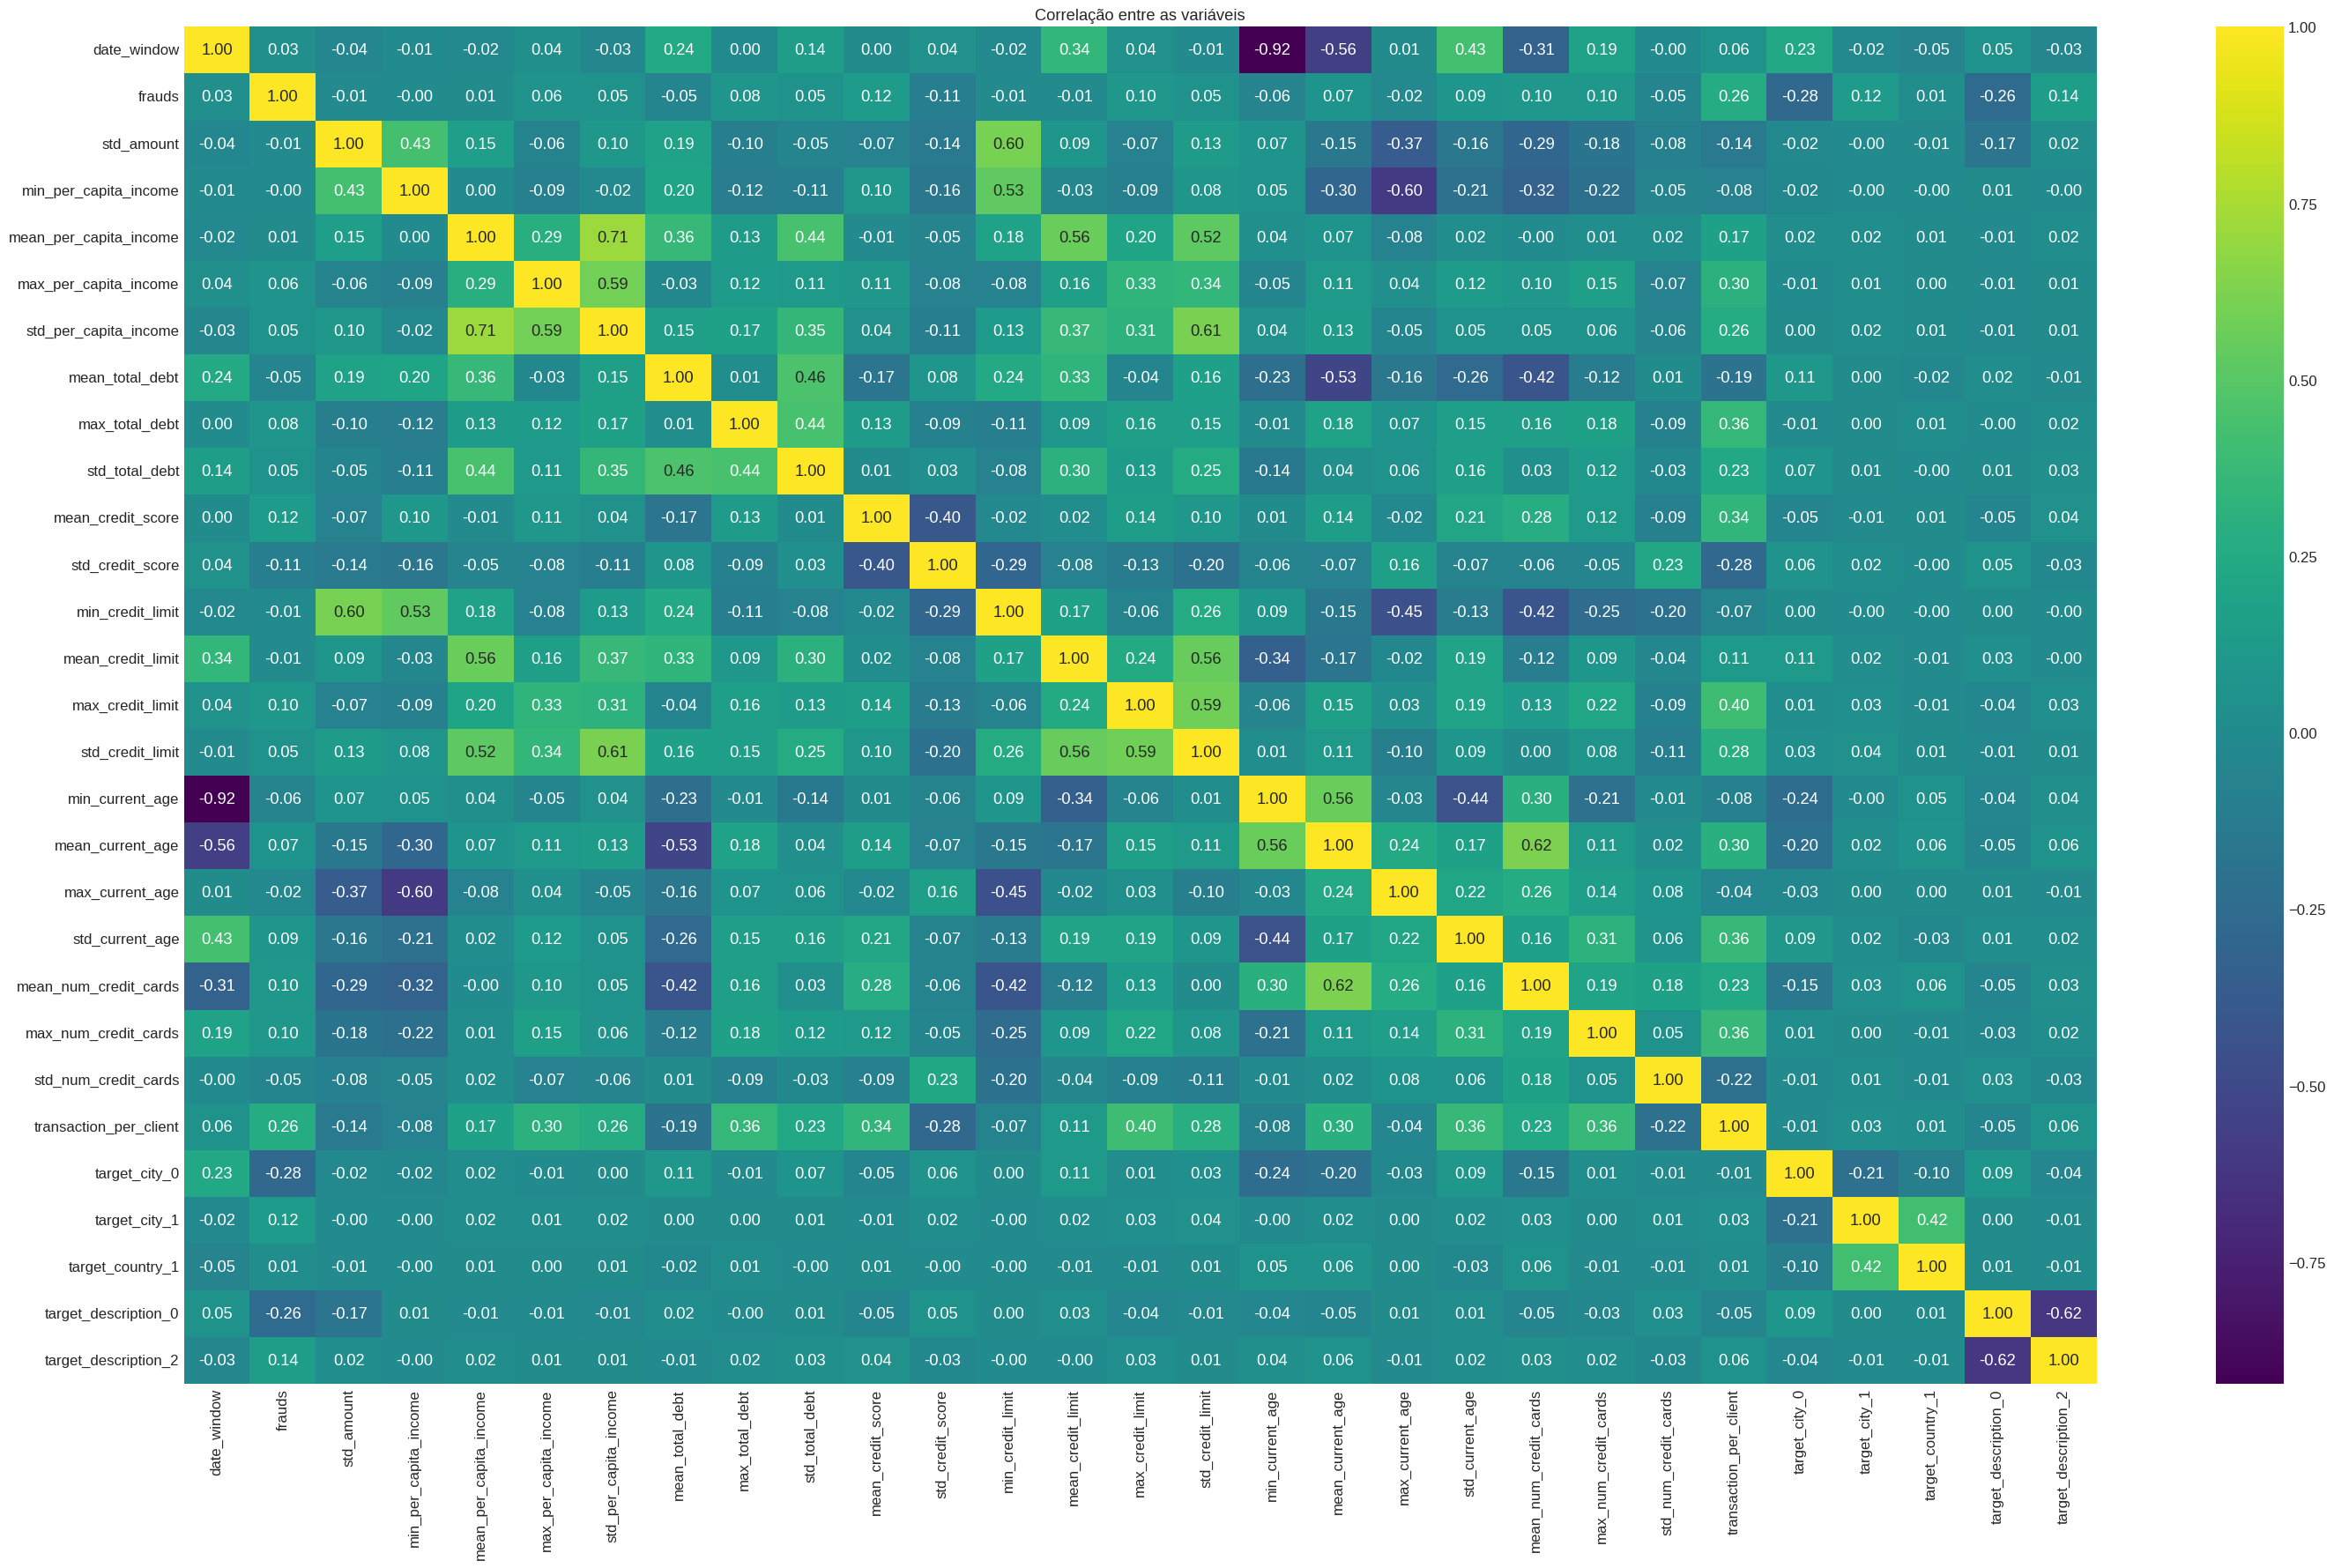

In [45]:
corr = selected_builder.df.corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

In [46]:
X = selected_builder.df.drop(columns=['date_window'])
y = X['frauds']

In [48]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
frauds,5387.0,2.383887e+00,4.496938,0.000000,0.000000,0.000000,3.000000,39.000000
std_amount,5387.0,7.340305e-02,0.014509,0.047448,0.065532,0.071971,0.079105,0.699717
min_per_capita_income,5387.0,6.532578e-03,0.289701,0.000000,0.000000,0.000000,0.000000,16.823000
mean_per_capita_income,5387.0,2.394482e+01,0.303430,21.167000,23.748599,23.942059,24.146754,28.301333
max_per_capita_income,5387.0,1.494995e+02,20.890112,30.747000,137.428000,163.145000,163.145000,163.145000
std_per_capita_income,5387.0,1.179839e+01,0.825447,5.599217,11.236988,11.782586,12.345386,20.099684
mean_total_debt,5387.0,5.785738e+00,0.142536,5.276819,5.691565,5.783895,5.875766,8.172533
max_total_debt,5387.0,4.469829e+01,4.536686,12.477100,46.185400,46.185400,46.185400,46.185400
std_total_debt,5387.0,5.181740e+00,0.192354,3.678802,5.057725,5.179750,5.308763,5.948495
mean_credit_score,5387.0,7.139771e+00,0.018170,7.071042,7.128469,7.140379,7.152305,7.314000


In [49]:
y.value_counts()

,count
frauds,
0,3283
1,374
2,263
3,242
4,185
5,172
6,127
7,111
8,105


### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [50]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

,Média,Variância
0,2.383887,20.222451


Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [51]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds']).columns)
formula

'frauds ~ std_amount + min_per_capita_income + mean_per_capita_income + max_per_capita_income + std_per_capita_income + mean_total_debt + max_total_debt + std_total_debt + mean_credit_score + std_credit_score + min_credit_limit + mean_credit_limit + max_credit_limit + std_credit_limit + min_current_age + mean_current_age + max_current_age + std_current_age + mean_num_credit_cards + max_num_credit_cards + std_num_credit_cards + transaction_per_client + target_city_0 + target_city_1 + target_country_1 + target_description_0 + target_description_2'

In [52]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()

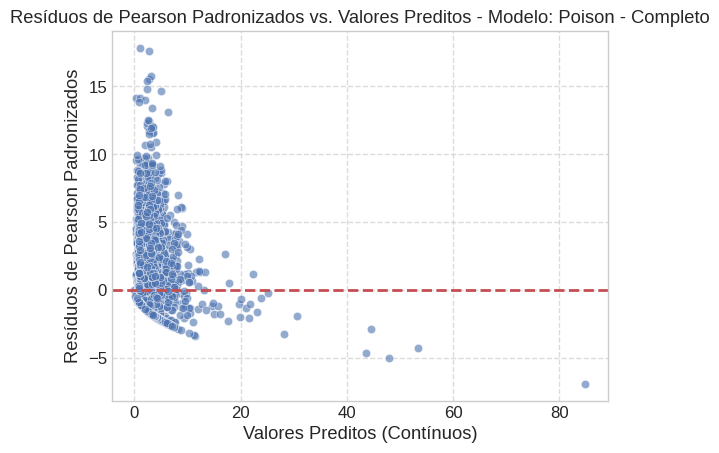

In [53]:
overdisp_plot(modelo_poisson, 'Poison - Completo')

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [54]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.066     
Dependent Variable:     ystar            AIC:                         44912.9601
Date:                   2025-08-16 20:50 BIC:                         44919.5519
No. Observations:       5387             Log-Likelihood:              -22455.   
Df Model:               1                F-statistic:                 380.7     
Df Residuals:           5386             Prob (F-statistic):          5.69e-82  
R-squared (uncentered): 0.066            Scale:                       244.50    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1839         0.0607       19.5107       0.0000       1.0650       1.3029
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [55]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('std_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('std_total_debt') + Q('mean_credit_score') + Q('std_credit_score') + Q('min_credit_limit') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('std_credit_limit') + Q('min_current_age') + Q('mean_current_age') + Q('max_current_age') + Q('std_current_age') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('std_num_credit_cards') + Q('transaction_per_client') + Q('target_city_0') + Q('target_city_1') + Q('target_country_1') + Q('target_description_0') + Q('target_description_2')

 Family type...: 
 Poisson

 Discarding atribute "Q('std_num_credit_cards')" with p-value equal to 0.6942448258497358 

Estimating model...: 
 frauds ~ Q('std_amount') + Q('min_per_capita_income') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('std_per

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5372
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16119.
Date:                Sat, 16 Aug 2025   Deviance:                       25253.
Time:                        20:50:40   Pearson chi2:                 3.08e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7554
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2235.1813     39.775     56.196      0.000    2157.224    2313.139
Q('std_amount')                -5.0550      0.820     -6.164      0.000      -6.662      -3.448
Q('min_per_capita_income')      0.1491      0.039      3.778      0.000       0.072       0.226
Q('mean_credit_score')          1.9527      0.571      3.421      0.001       0.834       3.072
Q('mean_credit_limit')         -3.7282      0.370    -10.069      0.000      -4.454      -3.002
Q('std_credit_limit')           0.3835      0.184      2.085      0.037       0.023       0.744
Q('min_current_age')           -0.1717      0.007    -23.959      0.000      -0.186      -0.158
Q('std_current_age')           -0.1972      0.038     -5.206      0.000      -0.271      -0.123
Q('mean_num_credit_cards')      2.7345      0.254     10.759      0.000       2.236       3.233
Q('transaction_per_client')     2.4565      0.054     45.392      0.000       2.350       2.563
Q('target_city_0')           -895.6983     19.297    -46.417      0.000    -933.519    -857.878
Q('target_city_1')           1066.3911     91.511     11.653      0.000     887.033    1245.749
Q('target_country_1')       -1086.0387    387.488     -2.803      0.005   -1845.501    -326.577
Q('target_description_0')   -1355.0969     35.558    -38.109      0.000   -1424.790   -1285.404
Q('target_description_2')    -188.1843     61.196     -3.075      0.002    -308.125     -68.243
===============================================================================================
"""

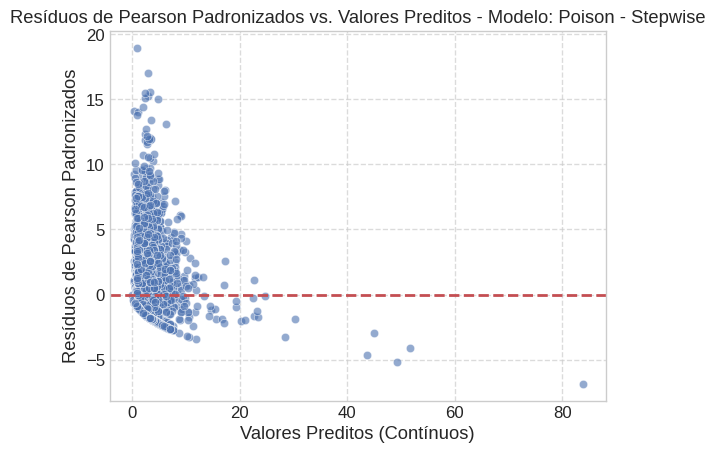

In [58]:
overdisp_plot(modelo_poisson_stepwise, 'Poison - Stepwise')

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [59]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.065     
Dependent Variable:     ystar            AIC:                         45005.9395
Date:                   2025-08-16 20:58 BIC:                         45012.5312
No. Observations:       5387             Log-Likelihood:              -22502.   
Df Model:               1                F-statistic:                 374.7     
Df Residuals:           5386             Prob (F-statistic):          9.40e-81  
R-squared (uncentered): 0.065            Scale:                       248.76    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.1866         0.0613       19.3566       0.0000       1.0664       1.3068
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [60]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

,Média,Variância
0,2.383887,20.222451


#### Implementação dos modelos

##### Completo

In [61]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5359
Model Family:        NegativeBinomial   Df Model:                           27
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9984.8
Date:                Sat, 16 Aug 2025   Deviance:                       9133.9
Time:                        21:03:39   Pearson chi2:                 1.04e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3305
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               3132.7450    122.854     25.500      0.000    2891.956    3373.534
std_amount                -4.5899      1.622     -2.830      0.005      -7.769      -1.411
min_per_capita_income      0.0943      0.101      0.933      0.351      -0.104       0.292
mean_per_capita_income    -0.0616      0.107     -0.575      0.565      -0.272       0.148
max_per_capita_income     -0.0020      0.001     -1.744      0.081      -0.004       0.000
std_per_capita_income      0.0365      0.041      0.882      0.378      -0.045       0.118
mean_total_debt            0.2301      0.213      1.081      0.280      -0.187       0.647
max_total_debt            -0.0042      0.005     -0.838      0.402      -0.014       0.006
std_total_debt             0.1625      0.139      1.172      0.241      -0.109       0.434
mean_credit_score          2.6621      1.169      2.277      0.023       0.371       4.954
std_credit_score           0.2997      1.420      0.211      0.833      -2.484       3.084
min_credit_limit         -68.9092    175.639     -0.392      0.695    -413.155     275.337
mean_credit_limit         -3.3892      0.809     -4.191      0.000      -4.974      -1.804
max_credit_limit          -0.0077      0.013     -0.591      0.555      -0.033       0.018
std_credit_limit           0.3462      0.466      0.743      0.458      -0.567       1.260
min_current_age           -0.1682      0.017     -9.791      0.000      -0.202      -0.135
mean_current_age          -0.0652      0.053     -1.234      0.217      -0.169       0.038
max_current_age           -0.0032      0.018     -0.179      0.858      -0.038       0.032
std_current_age           -0.1740      0.081     -2.154      0.031      -0.332      -0.016
mean_num_credit_cards      2.8546      0.530      5.385      0.000       1.816       3.894
max_num_credit_cards       0.1105      0.067      1.642      0.101      -0.021       0.242
std_num_credit_cards       0.0053      0.702      0.008      0.994      -1.371       1.382
transaction_per_client     2.3097      0.114     20.204      0.000       2.086       2.534
target_city_0          -1588.4539     73.870    -21.503      0.000   -1733.236   -1443.672
target_city_1            911.2838    351.212      2.595      0.009     222.922    1599.646
target_country_1       -1447.5924    892.587     -1.622      0.105   -3197.031     301.846
target_description_0   -1564.0628    101.650    -15.387      0.000   -1763.293   -1364.832
target_description_2    -296.9480    161.789     -1.835      0.066    -614.048      20.152
==========================================================================================
"""

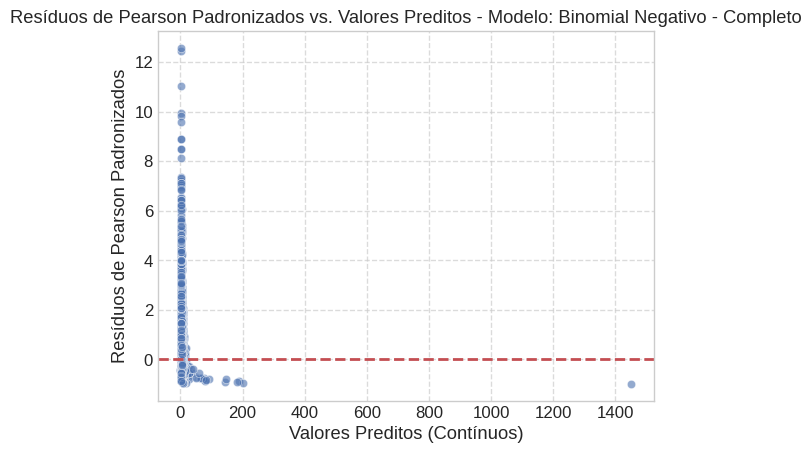

In [62]:
overdisp_plot(modelo_binomial, 'Binomial Negativo - Completo')

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

In [65]:
vuong_test(modelo_poisson, modelo_binomial)

NameError: name 'Poisson' is not defined